In [4]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, shape
from shapely.affinity import scale
#import geoplot

# Heart Disease Indicator Analysis

The purpose of this notebook is to explore two different datasets for their usability as the Heart Disease Indicator for CO

#### Dataset Info

The current dataset being used is the modeled prevalence of heart disease among adults (18+) per census tract. The alternative is the Mortality Rate per 100,000 persons where Heart Disease is listed as the primary cause of death.

Modeled Prevalence of Heart Disease: https://data-cdphe.opendata.arcgis.com/datasets/heart-disease-in-adults-cdphe-community-level-estimates-census-tracts?geometry=-119.613%2C35.977%2C-91.488%2C41.950

Heart Disease Mortality Rate: https://data-cdphe.opendata.arcgis.com/datasets/heart-disease-mortality-rate-census-tracts?geometry=-119.613%2C35.977%2C-91.488%2C41.950

#### CES methodology

CalEnviroScreen measures their Heart Disease indicator with the number of heart attack emergency department visits per 10,000 people 

This indicator was chosen "due to a lack of data on the prevalence of cardiovascular disease"

CO heart attack emergency department visits: https://coepht.colorado.gov/heart-attack-dataset-details

The following dataset includes data similar to that of the CES indicator, but is at the county level so a census-tract transformation would be necessary

### Surface-Level Pros and Cons

###### Modeled Prevalence

Pros
- Prevalence of heart disease is our ideal metric
- Data is at the census tract level
- The modeling used is well documented
- has less null values than mortality rate


Cons
- The data is based off modeling and not direct survey estimates
- The modeling uses the relationship between age, race, gender, poverty, education, location and health conditions or risk behavior indicators which means that any bias present in any of these indicators leaks into the modeling estimates



###### Mortality Rate

Pros
- A bit more empirical than modeled prevalence
- Although people survive heart attacks often we could justify using mortality as a measure of the effect of air pollution exposure since both short-term and long-term exposure lead to increase risk of death 
- In using mortality our justifcation needs to be stressed that the mortality is indicative of pollution exposure leading to death 


Cons
- As noted in the CES indicator description "many people surivive and return to a normal life after a heart attack" so mortality fails to capture all those who survive, but have a reduced quality of life
- 




###### Emergency Department Visits

Pros
- This is what CES is currently doing

Cons 
- Data is at the county level so conversion to census tract is necessary 
- CES is doing this in lieu of not having heart disease prevalence which we somewhat have with the modeled data

## Data Analysis

In [5]:
modeled = pd.read_csv("data/Heart_Disease_in_Adults__CDPHE_Community_Level_Estimates_Census_Tracts.csv")
mortality = pd.read_csv("data/Heart_Disease_Mortality_Rate__Census_Tracts_.csv")
visits = pd.read_excel("data/CO AMI HOSP AGE ADJUSTED.xlsx")

In [6]:
modeled.head()

,OBJECTID,Census_Tract_FIPS,Census_Tract_Name,County_Name,Adult_Population_Age18_and_over,Health_Statistics_Region,HeartDisease_Census_Tract_Estimate,HeartDisease_Estimate_Confidence_Interval,HeartDisease_Map_Symbol_withinHSR,HeartDisease_County_Regional_Estimate,HeartDisease_Map_Symbol_State,HeartDisease_State_Estimate
0,1,8043979000,"Census Tract 9790, Fremont County, Colorado",Fremont,2994,13,5.9,95% C.I.: 5.4 - 7.1,Highest Quintile,County/Regional Estimate 6% (95% C.I.: 3.7 - 8.3),Highest Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)
1,2,8045951600,"Census Tract 9516, Garfield County, Colorado",Garfield,2800,12,3.0,95% C.I.: 2.7 - 3.8,Highest Quintile,County/Regional Estimate 3.4% (95% C.I.: 1.6 -...,Middle Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)
2,3,8069002803,"Census Tract 28.03, Larimer County, Colorado",Larimer,97,2,0.5,95% C.I.: 0.5 - 0.6,Lowest Quintile,County/Regional Estimate 2.5% (95% C.I.: 2 - 3.1),Lowest Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)
3,4,8125963200,"Census Tract 9632, Yuma County, Colorado",Yuma,4381,1,5.8,95% C.I.: 4.8 - 9,Fourth Quintile,County/Regional Estimate 5.4% (95% C.I.: 2.4 -...,Highest Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)
4,5,8069002401,"Census Tract 24.01, Larimer County, Colorado",Larimer,1190,2,4.7,95% C.I.: 4.4 - 5.1,Highest Quintile,County/Regional Estimate 2.5% (95% C.I.: 2 - 3.1),Highest Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)


In [7]:
mortality.head()

,OBJECTID,TRACT_FIPS,TRACT_NAME,COUNTY_NAME,HD_ADJRATE,HD_L95CI,HD_U95CI,HD_STATEADJRATE,HD_SL95CI,HD_SU95CI,HD_DISPLAY
0,1,8043979000,"Census Tract 9790, Fremont County, Colorado",FREMONT,177.19,87.92,266.46,128.61,127.25,129.98,Not Different Than State Average
1,2,8045951600,"Census Tract 9516, Garfield County, Colorado",GARFIELD,28.07,9.04,57.60,128.61,127.25,129.98,Lower Than State Average
2,3,8069002803,"Census Tract 28.03, Larimer County, Colorado",LARIMER,NaN,NaN,NaN,128.61,127.25,129.98,No Events or Data Suppressed
3,4,8125963200,"Census Tract 9632, Yuma County, Colorado",YUMA,95.01,63.19,126.83,128.61,127.25,129.98,Lower Than State Average
4,5,8069002401,"Census Tract 24.01, Larimer County, Colorado",LARIMER,47.70,9.47,115.22,128.61,127.25,129.98,Lower Than State Average


In [8]:
visits.head()

,COUNTY,RATE,L95CL,U95CL,HOSP,FLAG,YEAR,gender,MEASURE,HealthOutcomeID,cofips
0,Statewide,19.453,18.6338,20.272,2185.0,2,2004,Female,Age adjusted rate,AMI,8000
1,Statewide,41.375,40.0127,42.738,3889.0,2,2004,Male,Age adjusted rate,AMI,8000
2,Statewide,29.457,28.7070,30.207,6074.0,2,2004,Both genders,Age adjusted rate,AMI,8000
3,Statewide,18.253,17.4680,19.037,2106.0,2,2005,Female,Age adjusted rate,AMI,8000
4,Statewide,38.488,37.2024,39.774,3787.0,2,2005,Male,Age adjusted rate,AMI,8000


Text(0.5,0,'HD Prevalence Estimate')

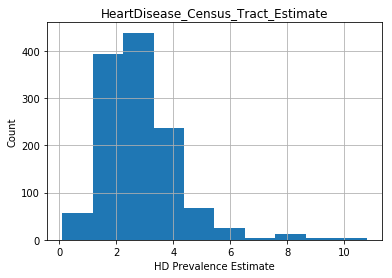

In [9]:

modeled.hist("HeartDisease_Census_Tract_Estimate")
plt.ylabel("Count")
plt.xlabel("HD Prevalence Estimate")

Text(0.5,0,'HD Mortality Rate')

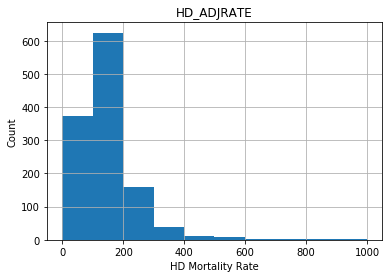

In [10]:
mortality.hist("HD_ADJRATE")
plt.ylabel("Count")
plt.xlabel("HD Mortality Rate")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd437373b70>]],
      dtype=object)

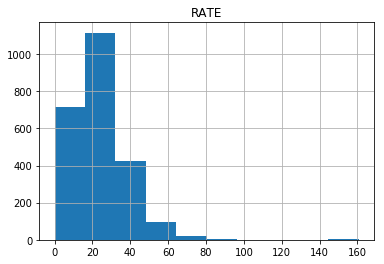

In [11]:
visits.hist("RATE")

Seeing if the lowest mortality rate and prevalance of heart disease match up

In [12]:
modeled[modeled["HeartDisease_Census_Tract_Estimate"] == min(modeled["HeartDisease_Census_Tract_Estimate"])]

,OBJECTID,Census_Tract_FIPS,Census_Tract_Name,County_Name,Adult_Population_Age18_and_over,Health_Statistics_Region,HeartDisease_Census_Tract_Estimate,HeartDisease_Estimate_Confidence_Interval,HeartDisease_Map_Symbol_withinHSR,HeartDisease_County_Regional_Estimate,HeartDisease_Map_Symbol_State,HeartDisease_State_Estimate
311,312,8069000600,"Census Tract 6, Larimer County, Colorado",Larimer,6433,2,0.1,95% C.I.: 0.1 - 0.4,Lowest Quintile,County/Regional Estimate 2.5% (95% C.I.: 2 - 3.1),Lowest Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)


In [13]:
mortality[mortality["HD_ADJRATE"] == min(mortality["HD_ADJRATE"])]

,OBJECTID,TRACT_FIPS,TRACT_NAME,COUNTY_NAME,HD_ADJRATE,HD_L95CI,HD_U95CI,HD_STATEADJRATE,HD_SL95CI,HD_SU95CI,HD_DISPLAY
35,36,8037000501,"Census Tract 5.01, Eagle County, Colorado",EAGLE,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
59,60,8097000500,"Census Tract 5, Pitkin County, Colorado",PITKIN,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
90,91,8083941100,"Census Tract 9411, Montezuma County, Colorado",MONTEZUMA,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
200,201,8001008548,"Census Tract 85.48, Adams County, Colorado",ADAMS,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
243,244,8001988700,"Census Tract 9887, Adams County, Colorado",ADAMS,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
429,430,8013012300,"Census Tract 123, Boulder County, Colorado",BOULDER,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
462,463,8123000300,"Census Tract 3, Weld County, Colorado",WELD,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
485,486,8014980100,"Census Tract 9801, Broomfield County, Colorado",BROOMFIELD,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
494,495,8014980300,"Census Tract 9803, Broomfield County, Colorado",BROOMFIELD,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed
513,514,8014980200,"Census Tract 9802, Broomfield County, Colorado",BROOMFIELD,0.0,0.0,0.0,128.61,127.25,129.98,No Events or Data Suppressed


Interesting to see that there are many 0 values which is also seen in the histogram, worth discussing which is more interesting as a datapoint here, additionally Larimer county does not show up whereas in the modeled data it had the lowest projected prevalence of heart disease, let's see what's going on there

In [14]:
mortality[mortality["TRACT_FIPS"] == 8069000600]

,OBJECTID,TRACT_FIPS,TRACT_NAME,COUNTY_NAME,HD_ADJRATE,HD_L95CI,HD_U95CI,HD_STATEADJRATE,HD_SL95CI,HD_SU95CI,HD_DISPLAY
311,312,8069000600,"Census Tract 6, Larimer County, Colorado",LARIMER,NaN,NaN,NaN,128.61,127.25,129.98,No Events or Data Suppressed


In [15]:
modeled[modeled["HeartDisease_Census_Tract_Estimate"] == max(modeled["HeartDisease_Census_Tract_Estimate"])]

,OBJECTID,Census_Tract_FIPS,Census_Tract_Name,County_Name,Adult_Population_Age18_and_over,Health_Statistics_Region,HeartDisease_Census_Tract_Estimate,HeartDisease_Estimate_Confidence_Interval,HeartDisease_Map_Symbol_withinHSR,HeartDisease_County_Regional_Estimate,HeartDisease_Map_Symbol_State,HeartDisease_State_Estimate
575,576,8011966700,"Census Tract 9667, Bent County, Colorado",Bent,4903,6,10.8,95% C.I.: 8 - 17.3,Highest Quintile,County/Regional Estimate 11.9% (95% C.I.: 2.9 ...,Highest Quintile,State Estimate 2.9% (95% C.I.: 2.7 - 3.0)


In [16]:
mortality[mortality["HD_ADJRATE"] == max(mortality["HD_ADJRATE"])]

,OBJECTID,TRACT_FIPS,TRACT_NAME,COUNTY_NAME,HD_ADJRATE,HD_L95CI,HD_U95CI,HD_STATEADJRATE,HD_SL95CI,HD_SU95CI,HD_DISPLAY
307,308,8001009407,"Census Tract 94.07, Adams County, Colorado",ADAMS,998.79,612.82,1384.77,128.61,127.25,129.98,Higher Than State Average


In [17]:
mortality['HD_ADJRATE'].isna().sum()

33

In [18]:
modeled["HeartDisease_Census_Tract_Estimate"].isna().sum()

9

There are 33 census tracts with null mortality rates whereas there are only 9 null HD estimated in the modeled data

In [19]:
mortality_shp = gpd.read_file("data/Heart_Disease_Mortality_Rate__Census_Tracts_.shp")
modeled_shp = gpd.read_file("data/Heart_Disease_in_Adults_-_CDPHE_Community_Level_Estimates__Census_Tracts_.shp")

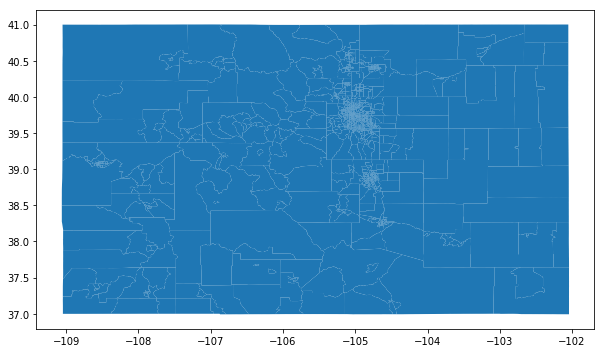

In [20]:
mortality_shp.plot(figsize=(10, 20))

In [21]:
#modeled_shp.plot(figsize = (10,20))

Forgot that the shape file won't auto shade, not exactly sure how to shade by percentile